# Config

In [ ]:
from ckanapi import RemoteCKAN
from dotenv import load_dotenv
import os
import pandas as pd
import geopandas as gpd
from pathlib import Path 
import requests
from io import StringIO, BytesIO # ADD BytesIO here
import keplergl

/home/lliebsch/Escritorio/REALLOCATE-pilot2/.venv/lib/python3.13/site-packages/ckanapi/version.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# ⚙️ Step 2: Set up connection and metadata

#Specific
DATASET_NAME = "streets_accessibility"
DATASET_TITLE = "Streets' Accessibility"
DATASET_DESCRIPTION = "Streets' accessibility in Barcelona city"
DATASET_TYPE = "microdata"
DATASET_ID = "157b8ef7-e437-4233-a684-edd440b9d3ce"
DATASET_FORMAT = "CSV"
DATASET_URL = f"{DATASET_TYPE}/export?id={DATASET_ID}&idResource=8c8cbb08-31e1-4c0b-92e5-c01e6598469c&fileformat={DATASET_FORMAT}"

#General
LOCATION = "../data/"
#CSV_FILE = f"{LOCATION}{DATASET_NAME}.csv"
#PARQUET_FILE = f"{LOCATION}{DATASET_NAME}.parquet"

#Reallocate params
REALLOCATE_URL = "https://reallocate-ckan.iti.gr"
REALLOCATE_KEY = os.getenv("REALLOCATE_KEY")
ckan = RemoteCKAN(REALLOCATE_URL, apikey=REALLOCATE_KEY)
ORG_INFO = ckan.action.organization_show(id="bsc")

#Open data params
API_KEY = os.getenv("API_KEY")
API_URL = "https://portaldades.ajuntament.barcelona.cat/services/backend/rest/"
headers = {'X-IBM-Client-Id': API_KEY}






# Get data

In [3]:
barris = gpd.read_parquet("../data/barris.parquet")
print(barris.shape)
print(barris.columns)

(73, 3)
Index(['BARRI', 'NOM', 'geometry'], dtype='object')


In [4]:
# Constants

# Fetch CSV content
data_response = requests.get((API_URL + DATASET_URL), headers=headers)

# Manually decode with correct encoding
decoded_text = data_response.content.decode('utf-8')  # or 'cp1252' if needed

# Load into StringIO for pandas
csv_file = StringIO(decoded_text)
raw_df = pd.read_csv(csv_file)

# Preview the data
print(raw_df.columns)
raw_df.head()

Index(['Gis_ID', 'N_Gis', 'Gis_X', 'Gis_Y', 'Longitud_X_WGS84',
       'Latitud_Y_WGS84', 'Incidència', 'Data d'Alta', 'Data de Baixa',
       'Situació', 'Tipus tram/carrer', 'Codi Grafo', 'ID Element Inventari',
       'Barri', 'Districte', 'Carrer', 'Numero Postal', 'Ubicació',
       'Accesibilitat', 'Tipus', 'Quantitat', 'Mesura', 'ALP Central',
       'ALP Façana', 'Adossat a façana (<0.50m)', 'Llargada', 'Amplada',
       'Amplada Gual', 'Amplada Pas de Vianants', 'Tipus Pas de Vianants',
       'Alçada', 'Amidament', 'Mesura mínima', 'Pendent Longitudinal',
       'Pendent Transversal', 'Pendent', 'Grao / Desnivell',
       'Tipus Direccional', 'Tipus Botons', 'Falta Direccional',
       'Falta Botons', 'Detall_Altres', 'Profunditat',
       'Cas No Compleix Mesura Longit.', 'Cas No Compleix Mesura Transv.',
       'Senyalització Horitzontal', 'Senyalització Vertical',
       'Reserva Accesible'],
      dtype='object')


/tmp/ipykernel_21982/1721884086.py:11: DtypeWarning: Columns (8,12,22,24,35,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv(csv_file)


,Gis_ID,N_Gis,Gis_X,Gis_Y,Longitud_X_WGS84,Latitud_Y_WGS84,Incidència,Data d'Alta,Data de Baixa,Situació,...,Tipus Botons,Falta Direccional,Falta Botons,Detall_Altres,Profunditat,Cas No Compleix Mesura Longit.,Cas No Compleix Mesura Transv.,Senyalització Horitzontal,Senyalització Vertical,Reserva Accesible
0,53,1,428568.7713,4.578089e+06,2.146111,41.351130,CanviNivell,13/4/2018 0:00:00,NaN,Tram,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54,2,428561.4783,4.578085e+06,2.146025,41.351097,Guals,13/4/2018 0:00:00,NaN,Cruïlla,...,NaN,NaN,NaN,NaN,120.0,NaN,NaN,NaN,NaN,NaN
2,55,3,428547.7503,4.578095e+06,2.145859,41.351181,AmpladaIlleta,13/4/2018 0:00:00,NaN,Cruïlla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75,4,431202.6671,4.582812e+06,2.177058,41.393901,Paviment,16/4/2018 0:00:00,NaN,Cruïlla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,76,5,431179.3580,4.582835e+06,2.176776,41.394107,Paviment,16/4/2018 0:00:00,NaN,Cruïlla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Process data
1. Filter the necessary rows.
2. Create new attributes
3. Make geodataframe
4. Evaluate
5. Keep needed rows

In [5]:
#Filter needed rows by 'Incidència'
df = raw_df[raw_df['Incidència'].isin(['Pendents', 'Obstacles', 'AmpladaLliure'])].copy()
print("Shape before filtering: ",raw_df.shape, "Shape after filtering: ", df.shape)

#Create new attributes
df = df.rename(columns={"Incidència": "Type",'Longitud_X_WGS84':"lon",'Latitud_Y_WGS84':"lat"})
df[["Value", "Evaluation","Description"]] = ["","",""] 

#Make geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Gis_X'], df['Gis_Y']),crs="EPSG:25831")

Shape before filtering:  (173144, 48) Shape after filtering:  (76527, 48)


## Evaluate by tresholds
I want an attribute with the value, and another with the evaluation

In [6]:
#Select specific rows
slope = gdf[gdf['Type'] == 'Pendents'].copy()
slope.dropna(subset=['Pendent Longitudinal','Pendent Transversal'], inplace=True)  # Ensure 'Pendents' is not NaN

# Assign columns using .loc to avoid warningsº
slope.loc[:, "Value"] = slope.apply(
    lambda row: f"Longitudinal {row['Pendent Longitudinal']}, Transversal {row['Pendent Transversal']}",
    axis=1
)

# Define evaluation logic row-wise
def evaluate(row):
    if row['Pendent Longitudinal'] == "<= 6%" and row['Pendent Transversal'] == "<= 2%":
        return "Accessible"
    else:
        return "Non accessible"

slope.loc[:, "Evaluation"] = slope.apply(evaluate, axis=1)

slope.loc[:, "Description"] = "Longitudinal and transversal unevenness of the sidewalk"

#Translate
slope = slope.replace({"Type": {"Pendents": "Slope"}})

slope[["Value","Type", "Evaluation", "Description"]].head()

,Value,Type,Evaluation,Description
21,"Longitudinal <= 6%, Transversal <= 2%",Slope,Accessible,Longitudinal and transversal unevenness of the...
59,"Longitudinal <= 6%, Transversal <= 2%",Slope,Accessible,Longitudinal and transversal unevenness of the...
99,"Longitudinal <= 6%, Transversal <= 2%",Slope,Accessible,Longitudinal and transversal unevenness of the...
141,"Longitudinal <= 6%, Transversal <= 2%",Slope,Accessible,Longitudinal and transversal unevenness of the...
181,"Longitudinal <= 6%, Transversal <= 2%",Slope,Accessible,Longitudinal and transversal unevenness of the...


In [7]:
#Select specific rows
obstacles = gdf[gdf['Type'] == 'Obstacles'].copy()
obstacles.dropna(subset=["ALP Façana"], inplace=True)  # Ensure 'Mesura' is not NaN

# # Assign columns using .loc to avoid warnings
mapping = {
    ">=1.80m": "Light",
    "1.50m<1.80m": "Moderate",
    "1.20m<1.50m": "Moderate",
    "0.90m<1.20m": "Moderate",
    "<0.90m": "Severe",
    "<=0.90m": "Severe",
    "": "No data"
}

obstacles.loc[:, "Value"] = obstacles["ALP Façana"]
obstacles.loc[:, "Evaluation"] = obstacles["ALP Façana"].map(mapping).fillna("Parcialment accessible")
obstacles.loc[:, "Description"] = "Obstacles of type " + obstacles["Tipus"]

#Translate
obstacles = obstacles.replace({"Type": {"Obstacles": "Obstacles"}})

obstacles[["Value","Type", "Evaluation", "Description"]].head()

,Value,Type,Evaluation,Description
137,>=1.80m,Obstacles,Light,Obstacles of type Reixes
174,>=1.80m,Obstacles,Light,Obstacles of type Reixes
175,>=1.80m,Obstacles,Light,Obstacles of type Reixes
206,>=1.80m,Obstacles,Light,Obstacles of type Aparcaments bicicleta
207,>=1.80m,Obstacles,Light,Obstacles of type Senyals verticals


In [8]:
#Select specific rows
width = gdf[gdf['Type'] == 'AmpladaLliure'].copy()
width.dropna(subset=["Mesura"], inplace=True)  # Ensure 'Mesura' is not NaN

# Fix large values with .loc
width.loc[width["Mesura"] >= 10000, "Mesura"] = width.loc[width["Mesura"] >= 10000, "Mesura"] / 100

# Assign columns using .loc to avoid warnings
width.loc[:, "Value"] = width["Mesura"]
width.loc[:, "Evaluation"] = width["Mesura"].apply(lambda x: "Accessible" if x >= 180 else "Parcialment accessible")
width.loc[:, "Description"] = "Width available for pedestrians or other sidewalk users"

#Translate
width = width.replace({"Type": {"AmpladaLliure": "Width"}})

width[["Value","Type", "Evaluation", "Description"]].head()

,Value,Type,Evaluation,Description
17,370.0,Width,Accessible,Width available for pedestrians or other sidew...
19,320.0,Width,Accessible,Width available for pedestrians or other sidew...
22,180.0,Width,Accessible,Width available for pedestrians or other sidew...
23,370.0,Width,Accessible,Width available for pedestrians or other sidew...
24,380.0,Width,Accessible,Width available for pedestrians or other sidew...


## Results layer

In [9]:
results = pd.concat([slope, obstacles, width], ignore_index=True)
results = results[["Gis_ID","Type","Value", "Evaluation", "Description", "geometry", "lat","lon"]]
results["Value"] = results["Value"].astype(str)
results.sort_values(by="Gis_ID").head()

,Gis_ID,Type,Value,Evaluation,Description,geometry,lat,lon
46941,98,Width,370.0,Accessible,Width available for pedestrians or other sidew...,POINT (431235.986 4582859.732),41.394333,2.177451
46942,100,Width,320.0,Accessible,Width available for pedestrians or other sidew...,POINT (431225.07 4582869.885),41.394424,2.177319
0,103,Slope,"Longitudinal <= 6%, Transversal <= 2%",Accessible,Longitudinal and transversal unevenness of the...,POINT (431227.311 4582869.933),41.394424,2.177346
46943,105,Width,180.0,Accessible,Width available for pedestrians or other sidew...,POINT (428635.088 4578118.05),41.351400,2.146901
46944,106,Width,370.0,Accessible,Width available for pedestrians or other sidew...,POINT (431264.038 4582934.616),41.395010,2.177778


In [10]:
mapping = {
    "Accessible": 0,
    "Parcialment accessible": 0.5,
    "Non accessible": 1,
    "Light": 0.33,
    "Moderate": 0.66,
    "Severe": 1}
results.loc[:, "Score"] = results["Evaluation"].map(mapping)
results["Score"].describe()

count    66595.000000
mean         0.395862
std          0.386165
min          0.000000
25%          0.000000
50%          0.330000
75%          0.660000
max          1.000000
Name: Score, dtype: float64

# Metrics

In [11]:
results["Value"].value_counts(dropna=False)

Value
Longitudinal <= 6%, Transversal <= 2%    13930
1.20m<1.50m                               6923
0.90m<1.20m                               5616
1.50m<1.80m                               4867
>=1.80m                                   4415
                                         ...  
2580.0                                       1
1925.0                                       1
985.0                                        1
2027.0                                       1
1130.0                                       1
Name: count, Length: 799, dtype: int64

In [12]:
results["Evaluation"].value_counts(dropna=False)

Evaluation
Accessible                29129
Moderate                  17406
Non accessible             6553
Severe                     4637
Parcialment accessible     4455
Light                      4415
Name: count, dtype: int64

In [13]:
results["Type"].value_counts(dropna=False)

Type
Obstacles    26458
Slope        20483
Width        19654
Name: count, dtype: int64

## Aggregate by Neightbourhoods

In [14]:
print(results.shape)

# Spatial join + aggregation + pivot in one flow
barris_agg = (
    gpd.sjoin(barris, results, how="inner", predicate="intersects")
    .groupby(["BARRI", "NOM", "Type"])
    .agg(Mean_Score=("Score", "mean"), Count=("Score", "count"))
    .reset_index()
    .pivot_table(
        index=["BARRI", "NOM"],
        columns="Type",
        values=["Mean_Score", "Count"],
        fill_value=0
    )
)

# Flatten MultiIndex and reset index
barris_agg.columns = [f"{stat}_{typ}" for stat, typ in barris_agg.columns]
barris_agg = barris_agg.reset_index()

# Compute totals and ponderated mean score
count_cols = [c for c in barris_agg if c.startswith("Count_")]
mean_cols = [c for c in barris_agg if c.startswith("Mean_Score_")]

barris_agg["Total_Count"] = barris_agg[count_cols].sum(axis=1)
barris_agg["Ponderated_Mean_Score"] = (
    (barris_agg[mean_cols].values * barris_agg[count_cols].values).sum(axis=1)
    / barris_agg["Total_Count"]
)
print(barris_agg.shape)
barris_agg.head()

# Add geometry back to the aggregated DataFrame
barris_agg = barris_agg.merge(barris[["BARRI", "geometry"]], on="BARRI", how="left")
barris_agg = gpd.GeoDataFrame(barris_agg, geometry="geometry", crs=barris.crs)
barris_agg.head()


(66595, 9)
(73, 10)


,BARRI,NOM,Count_Obstacles,Count_Slope,Count_Width,Mean_Score_Obstacles,Mean_Score_Slope,Mean_Score_Width,Total_Count,Ponderated_Mean_Score,geometry
0,01,el Raval,381.0,392.0,277.0,0.661549,0.043367,0.119134,1050.0,0.287667,"POLYGON ((430162.188 4581936.984, 430550.104 4..."
1,02,el Barri Gòtic,313.0,435.0,505.0,0.463482,0.241379,0.091089,1253.0,0.236289,"POLYGON ((431189.907 4581851.448, 431332.429 4..."
2,03,la Barceloneta,138.0,73.0,41.0,0.869420,0.054795,0.012195,252.0,0.493968,"POLYGON ((432798.734 4582081.26, 432805.852 45..."
3,04,"Sant Pere, Santa Caterina i la Ribera",321.0,433.0,382.0,0.737726,0.161663,0.035340,1136.0,0.281963,"POLYGON ((431733.736 4582441.816, 431827.673 4..."
4,05,el Fort Pienc,95.0,119.0,550.0,0.336947,0.033613,0.005455,764.0,0.051060,"POLYGON ((431741.815 4582625.649, 431645.093 4..."


# Visualize data

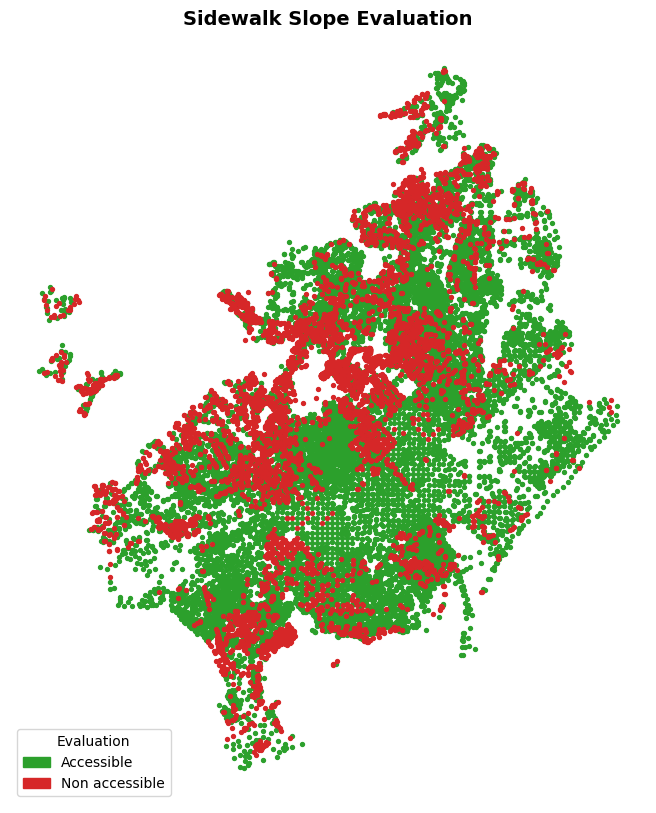

In [15]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches

# Define colors for each category (adjust as you like)
category_colors = {
    "Accessible": "#2ca02c",               # green
    "Non accessible": "#d62728",                      # red
}

# Ensure 'Evaluation' is a categorical column
slope["Evaluation"] = slope["Evaluation"].astype("category")

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each category separately so we control the legend colors
for category, color in category_colors.items():
    slope[slope["Evaluation"] == category].plot(
        ax=ax,
        color=color,
        markersize=8,
        label=category
    )

# Legend
handles = [mpatches.Patch(color=color, label=label) 
           for label, color in category_colors.items()]
ax.legend(handles=handles, title="Evaluation", loc="lower left")

# Remove axes
ax.set_axis_off()
ax.set_title("Sidewalk Slope Evaluation", fontsize=14, fontweight="bold")

plt.show()


<Axes: >

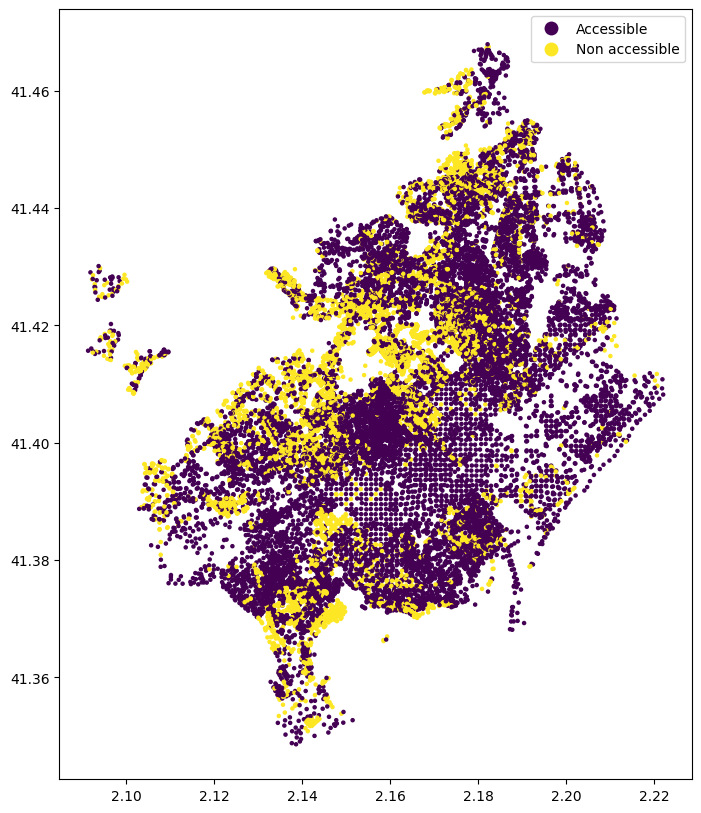

In [16]:
slope.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
slope.plot(
    column='Evaluation',
    legend=True,
    figsize=(10, 10),
    markersize=5,
    cmap='viridis'
)

<Axes: >

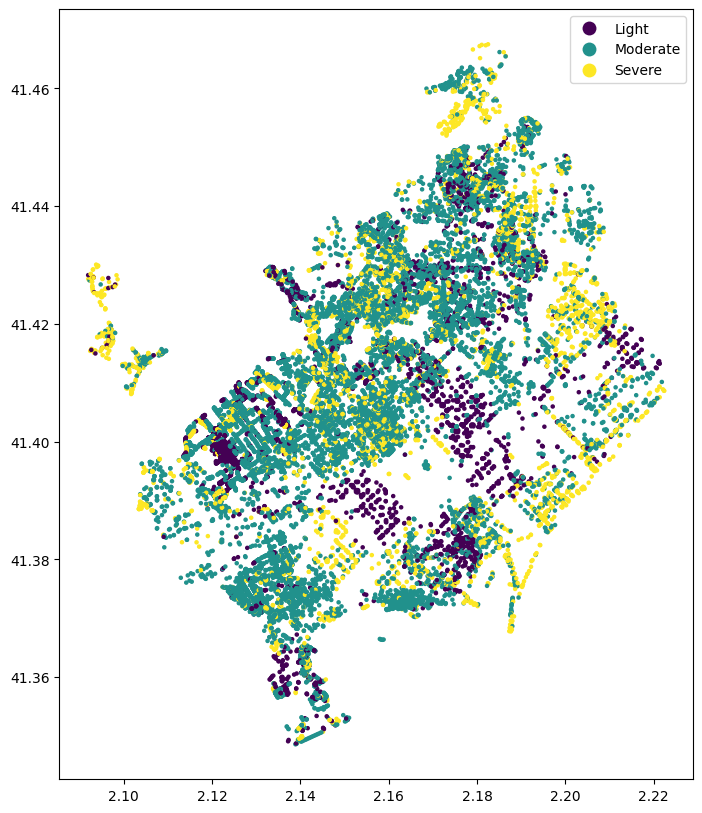

In [17]:
obstacles.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
obstacles.plot(
    column='Evaluation',
    legend=True,
    figsize=(10, 10),
    markersize=5,
    cmap='viridis'
)

<Axes: >

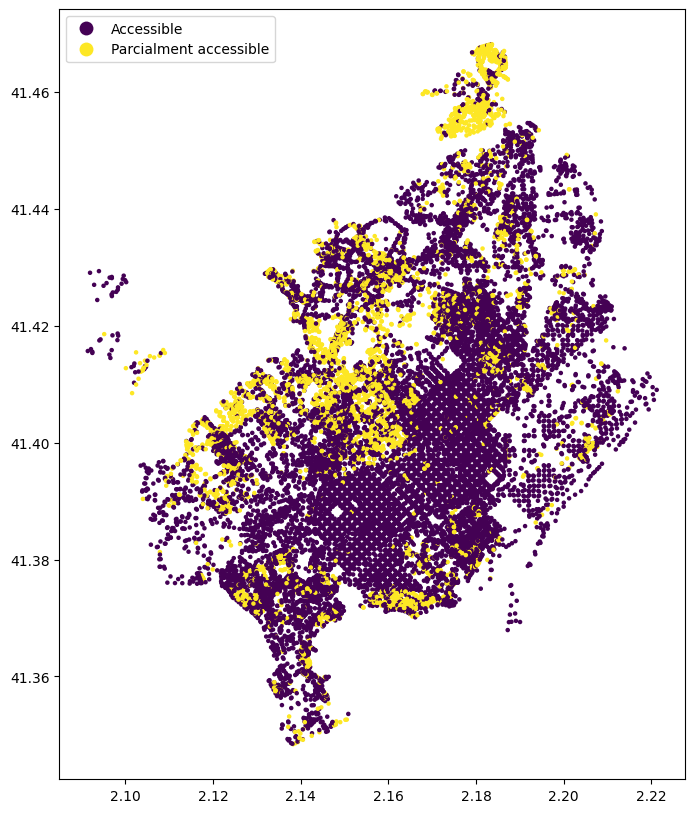

In [18]:
width.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
width.plot(
    column='Evaluation',
    legend=True,
    figsize=(10, 10),
    markersize=5,
    cmap='viridis'
)

<Axes: >

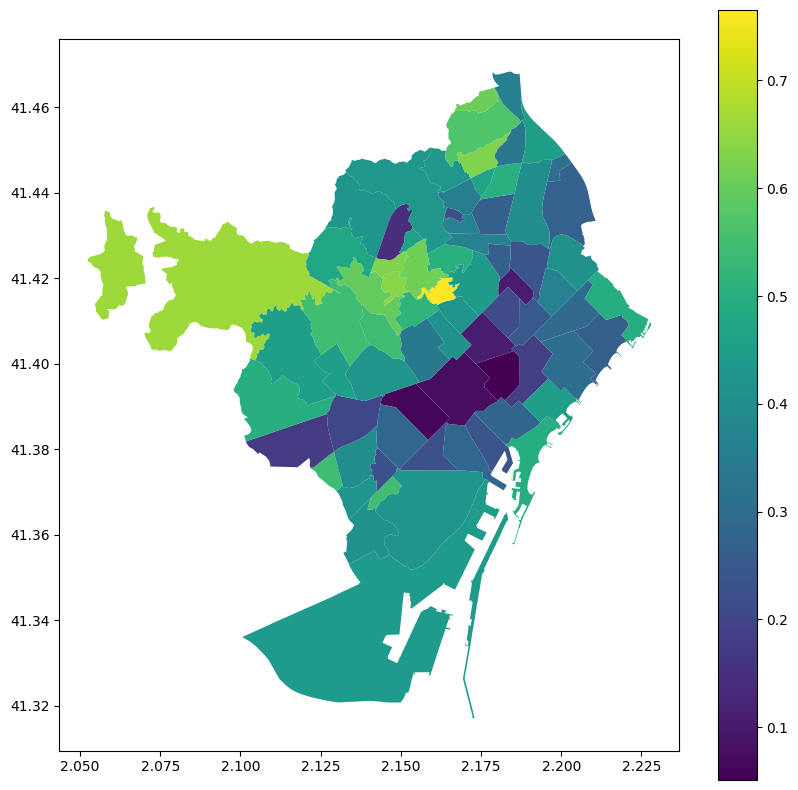

In [19]:
barris_agg.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility

barris_agg.plot(
    column='Ponderated_Mean_Score',
    legend=True,
    figsize=(10, 10),
    markersize=5,
    cmap='viridis'
)

# Fomat for Paula's code

In [20]:
for dataset in [slope, obstacles, width]:
    dataset.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
    dataset[["Gis_ID","Type","Value", "Evaluation", "Description", "geometry", "lat","lon"]].to_file(
        f"../data/IMPD_{dataset['Type'].iloc[0].lower()}.geojson", driver='GeoJSON', index=False)
results.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
results.to_file(
    f"../data/IMPD_all.geojson", driver='GeoJSON', index=False)
barris_agg.to_crs(epsg=4326, inplace=True)  # Convert to WGS84 for GeoJSON compatibility
barris_agg.to_file(
    f"../data/IMPD_barris.geojson", driver='GeoJSON', index=False)

# Save data
In this case, it will be in REALLOCATE CKAN

I